In [17]:
from typing import List, Callable
from dataclasses import dataclass, field
import numpy as np

In [ ]:
class GeneticAlgorithm():
    @dataclass
    class Constants():
        minimization: bool
        dims: int
        A: np.ndarray  # list of left borders (for each coordinate)
        B: np.ndarray  # list of right borders (for each coordinate)
        dX: np.ndarray
        mutation_chance: float
        N: int
        threshold: float
        max_generations: int = 1000

    @dataclass
    class PlotData():
        mean_x_history: list = field(default_factory=list)
        mean_y_history: list = field(default_factory=list)
        mean_fitness_history: list = field(default_factory=list)
        std_x_history: list = field(default_factory=list)
        std_y_history: list = field(default_factory=list)
        std_fitness_history: list = field(default_factory=list)
        
        best_y_history: list = field(default_factory=list)

    def __init__(self, f: Callable, constants: Constants):
        self.f0 = f
        self.f = f
        if constants.minimization:
            self.f = lambda X: -f(X)
        self.constants = constants
        self.constants.N = (self.constants.N + self.constants.N % 2) // 2 * 2
        
        # calculate gene_length & adjust dX
        m_vals = (self.constants.B - self.constants.A) // self.constants.dX
        self.gene_length = np.ceil(np.log2(m_vals + 1)).astype(int)                # np.ceil, np.log2
        self.constants.dX = (self.constants.B - self.constants.A) / (2 ** self.gene_length - 1)
        
        # initialize population
        population = []
        m_vals = ((self.constants.B - self.constants.A) // self.constants.dX).astype(int)
        for d in range(self.constants.dims):
            traits_10 = np.random.randint(0, m_vals[d] + 1, size=self.constants.N)  # np.random.randint
            traits_2 = [bin(val)[2:].zfill(self.gene_length[d]) for val in traits_10]
            population.append(traits_2)
        
        self.entities = np.array(population).T
        self.generation = 1
        self.plot_data = self.PlotData()

    def convert_to_X(self, entity: np.ndarray) -> np.ndarray:
        return self.constants.A + self.constants.dX * np.array([int(trait, 2) for trait in entity])

    def update_metrics(self):
        # renew y_array
        X_list = [self.convert_to_X(entity) for entity in self.entities]
        self.y_array = np.array([self.f(X) for X in X_list])
        self.old_best_entity, self.old_best_y = self.cur_best_entity, self.cur_best_y
        self.cur_best_entity, self.cur_best_y = max(zip(self.entities, self.y_array), key=lambda pair: pair[1])
        if self.cur_best_y > self.best_y:
            self.best_X = self.convert_to_X(self.cur_best_entity)
            self.best_y = self.cur_best_y * (-1 if self.constants.minimization else 1)

        # renew fitness_array    
        y_min = np.min(self.y_array)
        self.fitness_array = np.power(self.y_array - y_min, 4)
        
        # renew cumulative_ratios
        s = np.sum(self.fitness_array)                                            # np.sum
        if s == 0:
            ratios = np.full(len(self.fitness_array), 1/len(self.fitness_array))  # np.full
        else:
            ratios = self.fitness_array / s
        self.cumulative_ratios = np.cumsum(ratios)                                       # np.cumsum
        
        # save data for plots
        self.save_data_for_plots()
    
    
    def get_from_roulette(self) -> np.ndarray:
        r = np.random.random()                                       # np.random.random
        selected_index = np.searchsorted(self.cumulative_ratios, r)  # np.searchsorted
        return self.entities[selected_index]

    def mutate(self, entity: np.ndarray) -> None:
        for d in range(self.constants.dims):
            trait_array = np.array(list(entity[d]), dtype='U1')                                  
            mutation_mask = np.random.random(len(trait_array)) < self.constants.mutation_chance  # np.random.random
            trait_array[mutation_mask] = np.where(trait_array[mutation_mask] == '1', '0', '1')   # np.where
            entity[d] = ''.join(trait_array)

    def cross(self, ent1: np.ndarray, ent2: np.ndarray) -> List[np.ndarray]:
        parents = [ent1, ent2]
        children = []
        for _ in range(2):
            child = []
            for d in range(self.constants.dims):
                t = np.random.randint(1, self.gene_length[d] - 2)  # np.random.randint
                parent_indices = np.random.randint(0, 2, size=2)   # np.random.randint
                part1 = parents[parent_indices[0]][d][:t]    # np.random.randint
                part2 = parents[parent_indices[1]][d][t:]
                child.append(part1 + part2)
            children.append(np.array(child))
        return children
    

    def update_generation(self) -> None:
        children = []
        for _ in range(self.constants.N // 2):
            p1 = self.get_from_roulette()
            p2 = self.get_from_roulette()
            children.extend(self.cross(p1, p2))
        for child in children:
            self.mutate(child)
        self.entities = np.array(children)

    def conduct_evolution(self) -> None:
        self.best_y = -np.inf
        self.cur_best_y, self.cur_best_entity = -np.inf, None
        self.update_metrics()

        while True:
            self.update_generation()
            self.generation += 1
            self.update_metrics()
            
            if (0 < abs(self.cur_best_y - self.old_best_y) <= self.constants.threshold
                or self.generation > self.constants.max_generations):
                return

    def save_data_for_plots(self):
        X_list = np.array([self.convert_to_X(entity) for entity in self.entities])
        
        self.plot_data.mean_x_history.append(np.mean(X_list))
        self.plot_data.mean_y_history.append(np.mean(self.y_array))
        self.plot_data.mean_fitness_history.append(np.mean(self.fitness_array))
        self.plot_data.std_x_history.append(np.std(X_list))
        self.plot_data.std_y_history.append(np.std(self.y_array))
        self.plot_data.std_fitness_history.append(np.std(self.fitness_array))
        
        self.plot_data.best_y_history.append(self.cur_best_y)

        

In [ ]:
# Элитарный отбор (1-й вариант)

class EliteGeneticAlgorithmV1(GeneticAlgorithm):
    def __init__(self, f: Callable, constants: GeneticAlgorithm.Constants, elite_count: int):
        if elite_count < 0 or elite_count >= constants.N:
            raise ValueError()
        super().__init__(f, constants)
        self.constants.elite_count = elite_count
    
    def update_generation(self) -> None:
        if self.constants.elite_count == 0:
            super().update_generation()
            return
           
        best_indices = np.argpartition(-self.y_array, self.constants.elite_count)[:self.constants.elite_count]
        n_best_entities = self.entities[best_indices]
        
        self.constants.N -= self.constants.elite_count
        super().update_generation()
        self.constants.N += self.constants.elite_count
        self.entities = np.concatenate([self.entities, n_best_entities], axis=0)


In [ ]:
# Элитарный отбор (2-й вариант)

class EliteGeneticAlgorithmV2(GeneticAlgorithm):
    def __init__(self, f: Callable, constants: GeneticAlgorithm.Constants, elite_count: int):
        if elite_count < 0 or elite_count >= constants.N:
            raise ValueError()
        super().__init__(f, constants)
        self.constants.elite_count = elite_count
    
    def update_generation(self) -> None:
        if self.constants.elite_count == 0:
            super().update_generation()
            return
        
        best_indices = np.argpartition(-self.y_array, self.constants.elite_count)[:self.constants.elite_count]
        n_best_entities = self.entities[best_indices]
        
        super().update_generation()
        all_entities = np.concatenate([self.entities, n_best_entities], axis=0)
        y_array = np.array([self.f(self.convert_to_X(entity)) for entity in all_entities])
        idxs = np.argsort(y_array)[::-1]
        self.entities = all_entities[idxs][:self.constants.N]


In [ ]:
# Очистка


In [ ]:
# Скручивание
class CloseGeneticAlgorithm(GeneticAlgorithm):
    def replaceClosestParent(self): pass

In [ ]:
# Модифицированная рулетка
class ModifiedRouletteGA(GeneticAlgorithm):
    @dataclass
    class RouletteData():
        angle: float = field(default=0.0)  # от 0.0f до 1.0f
        count: int = field(default=0)  # от 0 до self.constants.N - 1
        
    def __init__(self):
        self.roulette_data = ModifiedRouletteGA.RouletteData()
    
    def getFromRoulette(self) -> np.ndarray:
        self.roulette_data.count %= self.constants.N
        if self.roulette_data.count == 0:
            self.roulette_data.angle = np.random.random()
            
        r = self.roulette_data.angle + self.roulette_data.count / self.constants.N  # np.random.random
        selected_index = np.searchsorted(self.cumulative_ratios, r)                      # np.searchsorted
        return self.entities[selected_index]
    

In [ ]:
# Трёхточечное скрещивание
class TernarCrossGA(GeneticAlgorithm):
    def cross(self, ent1: np.ndarray, ent2: np.ndarray) -> List[np.ndarray]:
        parents = [ent1, ent2]
        children = []
        for _ in range(2):
            child = []
            for d in range(self.constants.dims):
                l = self.gene_length[d]
                dots = [l//4, l//2, 3*l//4, -1]
                parent_idxs = np.random.randint(0, 4, size=2)   # np.random.randint
                parts = [parents[parent_idxs[i]][d][dots[i]:dots[i+1]] for i in range(3)]
                child.append(parts[0] + parts[1] + parts[2] + parts[3])
            children.append(np.array(child))
        return children

In [ ]:
########################################
# Выбор функции
if True:
    # Функция Розенброка
    border = 2.024
    consts = GeneticAlgorithm.Constants(
        minimization=True,
        dims=2,
        A=np.array([-border, -border]),
        B=np.array([border, border]),
        dX=np.array([0.001, 0.001]),
        mutation_chance=0.05,
        N=32,
        threshold=0.001
    )
    f = lambda X: (X[0] - 1) ** 2 + (X[1] - 1) ** 2 + 100 * (X[1] - X[0] ** 2) ** 2
else:
    # Функция абсолютной величины
    border = 10
    consts = GeneticAlgorithm.Constants(
        minimization=True,
        dims=2,
        A=np.array([-border, -border]),
        B=np.array([border, border]),
        dX=np.array([0.001, 0.001]),
        mutation_chance=0.05,
        N=32,
        threshold=0.001
    )
    f = lambda X: abs(X[0]) + abs(X[1])
    
########################################
# Выбор алгоритма
alg = 2
if alg == 0:
    population = GeneticAlgorithm(f, consts)
elif alg == 1:
    population = EliteGeneticAlgorithmV1(f, consts, int(consts.N * 0.1))
elif alg == 2:
    population = EliteGeneticAlgorithmV2(f, consts, int(consts.N * 0.1))


In [22]:
population.conduct_evolution()
print(f"Best solution: {population.f0(population.best_X):.3f}, X: {population.best_X}, generations: {population.generation}")

Best solution: 0.678, X: [0.84469255 0.6410569 ], generations: 83


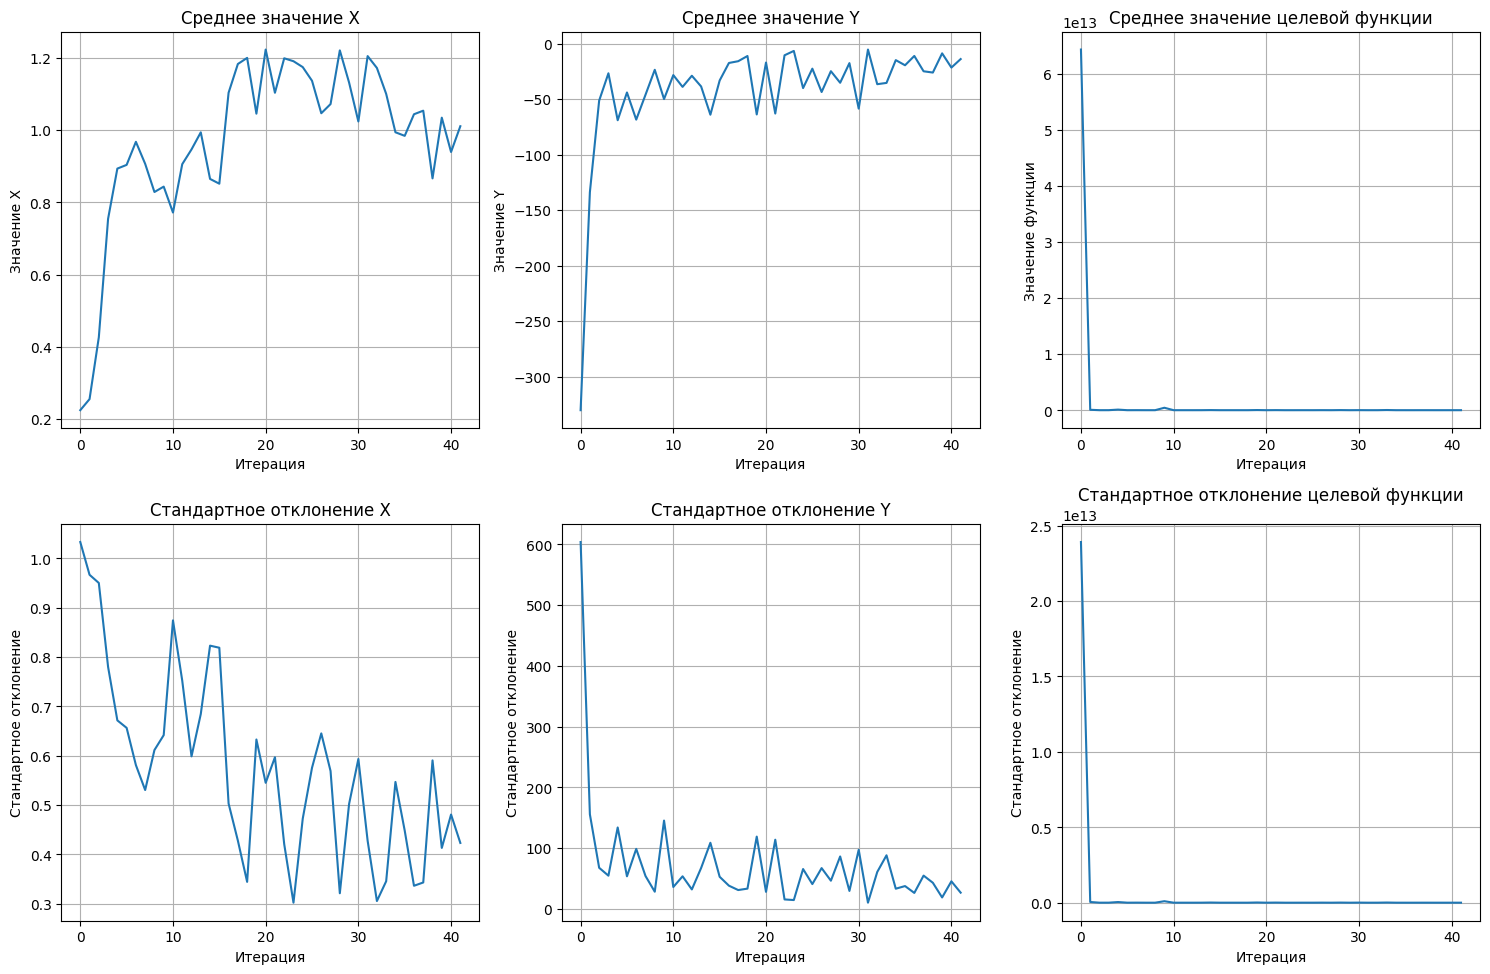

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
data = [
    (population.plot_data.mean_x_history, 'Среднее значение X', 'Значение X'),
    (population.plot_data.mean_y_history, 'Среднее значение Y', 'Значение Y'),
    (population.plot_data.mean_fitness_history, 'Среднее значение целевой функции', 'Значение функции'),
    (population.plot_data.std_x_history, 'Стандартное отклонение X', 'Стандартное отклонение'),
    (population.plot_data.std_y_history, 'Стандартное отклонение Y', 'Стандартное отклонение'),
    (population.plot_data.std_fitness_history, 'Стандартное отклонение целевой функции', 'Стандартное отклонение')
]
for i, (data_list, title, ylabel) in enumerate(data):
    row = i // 3
    col = i % 3
    axes[row, col].plot(data_list)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Итерация')
    axes[row, col].set_ylabel(ylabel)
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

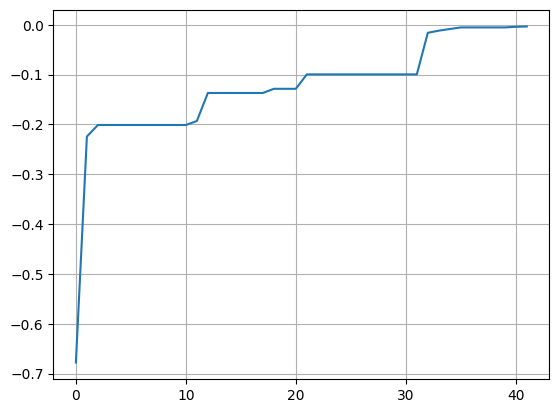

In [24]:
import matplotlib.pyplot as plt

plt.plot(population.plot_data.best_y_history)
plt.grid(True)
plt.show()